In [ ]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab
from sklearn.cluster import KMeans  ### NÃO SUPERVISIONADA
from sklearn.decomposition import PCA   ### NÃO SUPERVISIONADA
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import silhouette_score  ### AVALIAR ALGORITIMOS DE CLUSTERIZAÇÃO
import warnings
import joblib
warnings.filterwarnings("ignore")
!pip install Prophet
from prophet import Prophet  ### PREVISÃO DE VENDAS

In [ ]:

import pandas as pd
from prophet import Prophet
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Carregar os dados
dados_frame1 = pd.read_csv('https://relacoesinstitucionais.com.br/Fotos/Temp/dados_csv_Boston_sem_outliers.csv')
dados_frame2 = pd.read_csv('https://relacoesinstitucionais.com.br/Fotos/Temp/dados_csv_New_York_sem_outliers.csv')
dados_frame3 = pd.read_csv('https://relacoesinstitucionais.com.br/Fotos/Temp/dados_csv_Philadelphia_sem_outliers.csv')

dados_filtrados = dados_frame3


In [ ]:
dados_filtrados

,year_month,year,month,item,item2,store2,sales,mean_price,store,region,SOMA,Cluster
0,2011-02-01,2011,2,ACCESORIES_1_004,3,4,15,5.7722,Midtown_Village,2,86.5830,1
1,2011-02-01,2011,2,ACCESORIES_1_008,7,4,184,0.5852,Midtown_Village,2,107.6768,2
2,2011-02-01,2011,2,ACCESORIES_1_008,7,9,56,0.6118,Yorktown,2,34.2608,1
3,2011-02-01,2011,2,ACCESORIES_1_008,7,5,144,0.5852,Queen_Village,2,84.2688,2
4,2011-02-01,2011,2,ACCESORIES_1_009,8,9,14,2.1280,Yorktown,2,29.7920,1
...,...,...,...,...,...,...,...,...,...,...,...,...
334127,2015-12-01,2015,12,SUPERMARKET_3_826,3047,9,27,1.5360,Yorktown,2,41.4720,0
334128,2015-12-01,2015,12,SUPERMARKET_3_826,3047,5,38,1.5360,Queen_Village,2,58.3680,0
334129,2015-12-01,2015,12,SUPERMARKET_3_827,3048,4,84,1.2000,Midtown_Village,2,100.8000,0
334130,2015-12-01,2015,12,SUPERMARKET_3_827,3048,9,60,1.2000,Yorktown,2,72.0000,0


In [ ]:
## CARREGANDO O DATASET

dados_csv = pd.read_csv('https://relacoesinstitucionais.com.br/Fotos/Temp/base_mensal.csv')

In [ ]:
## TRANSFORMANDO PARA DATAFRAME

dados_frame = pd.DataFrame(dados_csv)


In [ ]:
#dados_frame[(dados_frame['item'] == 'ACCESORIES_1_001') & (dados_frame['region'] == 'Boston')]


In [ ]:
### CRIANDO LABEL PARA OS CATEGÓRICOS

from sklearn.preprocessing import LabelEncoder
import pandas as pd


label_encoder = LabelEncoder()


dados_frame['store2'] = label_encoder.fit_transform(dados_frame['store'])
dados_frame['item2'] = label_encoder.fit_transform(dados_frame['item'])
dados_frame['year_month'] = pd.to_datetime(dados_frame['year_month'])
dados_frame['month'] = dados_frame['year_month'].dt.month
dados_frame['year'] = dados_frame['year_month'].dt.year
dados_frame['region'] = label_encoder.fit_transform(dados_frame['region'])
dados_frame['SOMA'] = dados_frame['sales'] * dados_frame['mean_price']
dados_frame = dados_frame[dados_frame['year'] != 2016]
dados_frame = dados_frame[dados_frame['year_month'] != '2011-01']
dados_frame = dados_frame[['year_month', 'year', 'month', 'item', 'item2', 'store2', 'sales', 'mean_price', 'store', 'region', 'SOMA']]


In [ ]:
### RETIRANDO DADOS SEM VENDAS E AQUELES COM MÉDIA DE PREÇO SEM DADOS

dados_frame = dados_frame[dados_frame['sales'] != 0]
dados_frame = dados_frame[~(dados_frame['mean_price'].isna() & (dados_frame['sales'] > 0))]


In [ ]:
### SEPARANDO DATASET POR REGIÃO

dados_csv_Boston = dados_frame[(dados_frame['region'] == 0)]
dados_csv_New_York = dados_frame.loc[(dados_frame['region'] == 1)]
dados_csv_Philadelphia = dados_frame.loc[(dados_frame['region'] == 2)]

In [ ]:
### RETIRANDO OUTLIERS DO PRIMEIRO E QUARTO QUARTIS - BOSTON

Q1 = dados_csv_Boston['SOMA'].quantile(0.25)
Q3 = dados_csv_Boston['SOMA'].quantile(0.75)
IQR = Q3 - Q1

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

dados_csv_Boston_sem_outliers = dados_csv_Boston[(dados_csv_Boston['SOMA'] >= limite_inferior) & (dados_csv_Boston['SOMA'] <= limite_superior)]


### RETIRANDO OUTLIERS DO PRIMEIRO E QUARTO QUARTIS - NEWYORK

Q1 = dados_csv_New_York['SOMA'].quantile(0.25)
Q3 = dados_csv_New_York['SOMA'].quantile(0.75)
IQR = Q3 - Q1

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

dados_csv_New_York_sem_outliers = dados_csv_New_York[(dados_csv_New_York['SOMA'] >= limite_inferior) & (dados_csv_New_York['SOMA'] <= limite_superior)]

### RETIRANDO OUTLIERS DO PRIMEIRO E QUARTO QUARTIS - Philadelphia

Q1 = dados_csv_Philadelphia['SOMA'].quantile(0.25)
Q3 = dados_csv_Philadelphia['SOMA'].quantile(0.75)
IQR = Q3 - Q1

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

dados_csv_Philadelphia_sem_outliers = dados_csv_Philadelphia[(dados_csv_Philadelphia['SOMA'] >= limite_inferior) & (dados_csv_Philadelphia['SOMA'] <= limite_superior)]



In [ ]:
### PADRONIZANDO OS DADOS

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()


dados_csv_Boston_sem_outliers = scaler.fit_transform(dados_csv_Boston_sem_outliers[['item2', 'sales', 'mean_price']])
dados_csv_New_York_sem_outliers = scaler.fit_transform(dados_csv_New_York_sem_outliers[['item2', 'sales', 'mean_price']])
dados_csv_Philadelphia_sem_outliers = scaler.fit_transform(dados_csv_Philadelphia_sem_outliers[['item2', 'sales', 'mean_price']])


In [ ]:
### UTILIZANDO 1% PARA NÃO PESAR NO PROCESSAMENTO DA CURVA DE ELBOW

dados_csv_Boston_sem_outliers_MENOR, dados_csv_Boston_sem_outliers_MAIOR = train_test_split(dados_csv_Boston_sem_outliers2, train_size = 0.1)     ###pega 1% pra não comprometer a memória do PC


dados_csv_New_York_sem_outliers_MENOR, dados_csv_New_York_sem_outliers_MAIOR = train_test_split(dados_csv_New_York_sem_outliers, train_size = 0.1)     ###pega 1% pra não comprometer a memória do PC


dados_csv_Philadelphia_sem_outliers_MENOR, dados_csv_Philadelphia_sem_outliers_MAIOR = train_test_split(dados_csv_Philadelphia_sem_outliers, train_size = 0.1)     ###pega 1% pra não comprometer a memória do PC


dados_csv_Boston_sem_outliers_MENOR.shape, dados_csv_Boston_sem_outliers_MAIOR.shape
dados_csv_New_York_sem_outliers_MENOR.shape, dados_csv_New_York_sem_outliers_MAIOR.shape
dados_csv_Philadelphia_sem_outliers_MENOR.shape, dados_csv_Philadelphia_sem_outliers_MAIOR.shape



((33413, 11), (300719, 11))

In [ ]:
### ALGORITIMO KMEANS - DADOS BOSTON

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
pca = PCA(n_components=2)

## UTILIZANDO O PCA, EM DADOS JÁ NORMALIZADOS
componentes_principais_boston = pca.fit_transform(dados_csv_Boston_sem_outliers)
componentes_principais_newyork = pca.fit_transform(dados_csv_New_York_sem_outliers)
componentes_principais_philadelphia = pca.fit_transform(dados_csv_Philadelphia_sem_outliers)

componentes_principais_boston = pd.DataFrame(componentes_principais_boston, columns=['Componente 1', 'Componente 2'])
componentes_principais_newyork = pd.DataFrame(componentes_principais_newyork, columns=['Componente 1', 'Componente 2'])
componentes_principais_philadelphia = pd.DataFrame(componentes_principais_philadelphia, columns=['Componente 1', 'Componente 2'])

#df = pd.DataFrame(componentes_principais)

kmeans_boston = KMeans(n_clusters=5, random_state=42, n_init=10, max_iter=300)
kmeans_boston.fit(componentes_principais_boston)
kmeans_newyork = KMeans(n_clusters=5, random_state=42, n_init=10, max_iter=300)
kmeans_newyork.fit(componentes_principais_newyork)
kmeans_philadelphia = KMeans(n_clusters=5, random_state=42, n_init=10, max_iter=300)
kmeans_philadelphia.fit(componentes_principais_philadelphia)






KMeans(n_clusters=5, n_init=10, random_state=42)

In [ ]:
dados_csv_Boston_sem_outliers['Cluster'] = kmeans_boston.labels_
dados_csv_New_York_sem_outliers['Cluster'] = kmeans_newyork.labels_
dados_csv_Philadelphia_sem_outliers['Cluster'] = kmeans_philadelphia.labels_

In [ ]:
dados_csv_Boston_sem_outliers.to_csv('dados_csv_Boston_sem_outliers.csv', index=False)
dados_csv_New_York_sem_outliers.to_csv('dados_csv_New_York_sem_outliers.csv', index=False)
dados_csv_Philadelphia_sem_outliers.to_csv('dados_csv_Philadelphia_sem_outliers.csv', index=False)


In [ ]:
### PLOTANDO O RESULTADO - E OS CENTRÓIDES

plt.figure(figsize=(20, 10))
#scatter = plt.scatter(dados_csv_Boston_sem_oudftliers['0'], dados_csv_Boston_sem_outliers['1'], c=dados_csv_Boston_sem_outliers['Grupo'], cmap='viridis')
scatter = plt.scatter(df['Componente 1'], df['Componente 2'], c=df['Grupo'], cmap='viridis', label='Dados')
plt.xlabel('0')
plt.ylabel('1')
plt.title('Agrupamento de Produtos')


# Adicionar centroides
centroids = kmeans_TREINADO.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=300, alpha=0.6, label='Centroides')

# Adicionar legenda
plt.legend(*scatter.legend_elements(), title="Grupos")
plt.legend()

plt.show()

In [ ]:
# VERIFICANDO O SILHOUETTE_SCORE

from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(df, df['Grupo'])

print(f"A pontuação de silhueta média é: {silhouette_avg}")

A pontuação de silhueta média é: 0.6523297129857153


In [ ]:
#EXPORTAR ALGORITIMO

#joblib.dump(kmeans_TREINADO, 'kmeans_model_Boston.pkl')
#print("Modelo salvo como 'kmeans_model.pkl'")

In [ ]:
dados_filtrados = dados_csv_Boston_sem_outliers

In [ ]:
dados_filtrados

,year_month,year,month,item,item2,store2,sales,mean_price,store,region,SOMA,Cluster
30520,2011-02-01,2011,2,ACCESORIES_1_004,3,7,43,5.7722,South_End,0,248.2046,4
30560,2011-02-01,2011,2,ACCESORIES_1_008,7,7,101,0.5719,South_End,0,57.7619,2
30561,2011-02-01,2011,2,ACCESORIES_1_008,7,6,123,0.5852,Roxbury,0,71.9796,2
30562,2011-02-01,2011,2,ACCESORIES_1_008,7,0,83,0.6384,Back_Bay,0,52.9872,2
30570,2011-02-01,2011,2,ACCESORIES_1_009,8,7,34,2.0748,South_End,0,70.5432,4
...,...,...,...,...,...,...,...,...,...,...,...,...
1829380,2015-12-01,2015,12,SUPERMARKET_3_826,3047,7,21,1.5360,South_End,0,32.2560,0
1829381,2015-12-01,2015,12,SUPERMARKET_3_826,3047,6,43,1.5360,Roxbury,0,66.0480,0
1829382,2015-12-01,2015,12,SUPERMARKET_3_826,3047,0,20,1.5360,Back_Bay,0,30.7200,0
1829390,2015-12-01,2015,12,SUPERMARKET_3_827,3048,7,23,1.2000,South_End,0,27.6000,0


In [ ]:
dados_filtrados_cluster_selecionado = dados_filtrados[dados_filtrados['Cluster'] == 2]


In [ ]:
dados_filtrados_cluster_selecionado    # SE DEIXAR ABERTO, MOSTRA TUDO

,year_month,year,month,item,item2,store2,sales,mean_price,store,region,SOMA,Cluster
30560,2011-02-01,2011,2,ACCESORIES_1_008,7,7,101,0.5719,South_End,0,57.7619,2
30561,2011-02-01,2011,2,ACCESORIES_1_008,7,6,123,0.5852,Roxbury,0,71.9796,2
30562,2011-02-01,2011,2,ACCESORIES_1_008,7,0,83,0.6384,Back_Bay,0,52.9872,2
30571,2011-02-01,2011,2,ACCESORIES_1_009,8,6,76,2.0748,Roxbury,0,157.6848,2
30630,2011-02-01,2011,2,ACCESORIES_1_015,14,7,91,0.9443,South_End,0,85.9313,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1829132,2015-12-01,2015,12,SUPERMARKET_3_801,3022,0,90,1.2000,Back_Bay,0,108.0000,2
1829191,2015-12-01,2015,12,SUPERMARKET_3_807,3028,6,89,2.3760,Roxbury,0,211.4640,2
1829280,2015-12-01,2015,12,SUPERMARKET_3_816,3037,7,133,0.2400,South_End,0,31.9200,2
1829281,2015-12-01,2015,12,SUPERMARKET_3_816,3037,6,161,0.2400,Roxbury,0,38.6400,2


In [ ]:
dados_filtrados_cluster_selecionado2 = dados_filtrados_cluster_selecionado[['year_month', 'item', 'store', 'SOMA']]



In [ ]:
dados_filtrados_cluster_selecionado2 ## selecionou item só, agrupar store e soma    ## seleciou item + store



,year_month,item,store,SOMA
30560,2011-02-01,ACCESORIES_1_008,South_End,57.7619
30561,2011-02-01,ACCESORIES_1_008,Roxbury,71.9796
30562,2011-02-01,ACCESORIES_1_008,Back_Bay,52.9872
30571,2011-02-01,ACCESORIES_1_009,Roxbury,157.6848
30630,2011-02-01,ACCESORIES_1_015,South_End,85.9313
...,...,...,...,...
1829132,2015-12-01,SUPERMARKET_3_801,Back_Bay,108.0000
1829191,2015-12-01,SUPERMARKET_3_807,Roxbury,211.4640
1829280,2015-12-01,SUPERMARKET_3_816,South_End,31.9200
1829281,2015-12-01,SUPERMARKET_3_816,Roxbury,38.6400


In [ ]:
# FILTRANDO ITEM E STORE
#dados_filtrados_cluster_selecionado3 = dados_filtrados_cluster_selecionado2[(dados_filtrados_cluster_selecionado2['item'] == 'ACCESORIES_1_008') & (dados_filtrados_cluster_selecionado2['store'] == 'South_End')]
dados_filtrados_cluster_selecionado3 = dados_filtrados_cluster_selecionado2.groupby(['year_month'])['SOMA'].sum().reset_index()

In [ ]:
#selecionados = dados_filtrados_cluster_selecionado3[['year_month', 'SOMA']]
selecionados = dados_filtrados_cluster_selecionado3

In [ ]:
selecionados

,year_month,SOMA
0,2011-02-01,84150.579200
1,2011-03-01,80708.581100
2,2011-04-01,81369.549125
3,2011-05-01,79457.614360
4,2011-06-01,79944.519100
5,2011-07-01,76161.317500
6,2011-08-01,76384.806180
7,2011-09-01,78507.757700
8,2011-10-01,90131.636075
9,2011-11-01,80342.496250


In [ ]:
!pip install Prophet
from prophet import Prophet

selecionados.columns = ['ds', 'y']

In [ ]:
selecionados['ds'] = selecionados['ds'].dt.strftime('%Y-%m')

In [ ]:
# Fit the model
m = Prophet(interval_width=0.95, daily_seasonality=False)
model = m.fit(selecionados)


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_j2q1szg/awutq0t7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_j2q1szg/0wa1ujws.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97290', 'data', 'file=/tmp/tmp_j2q1szg/awutq0t7.json', 'init=/tmp/tmp_j2q1szg/0wa1ujws.json', 'output', 'file=/tmp/tmp_j2q1szg/prophet_modelff6drw70/prophet_model-20241011025642.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:56:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:56:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = m.make_future_dataframe(periods=20, freq = 'MS')
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
74,2017-04-01,113493.306624,105111.620275,118051.700829,113149.878460,113808.773605,-1945.848916,-1945.848916,-1945.848916,-1945.848916,-1945.848916,-1945.848916,0.0,0.0,0.0,111547.457708
75,2017-05-01,113912.696765,103539.684766,117201.073436,113537.324640,114262.834288,-3520.774565,-3520.774565,-3520.774565,-3520.774565,-3520.774565,-3520.774565,0.0,0.0,0.0,110391.922200
76,2017-06-01,114346.066578,108670.888757,121992.833748,113942.442368,114728.456336,1137.709968,1137.709968,1137.709968,1137.709968,1137.709968,1137.709968,0.0,0.0,0.0,115483.776546
77,2017-07-01,114765.456720,107359.762374,120935.678819,114330.026094,115185.817701,-707.307330,-707.307330,-707.307330,-707.307330,-707.307330,-707.307330,0.0,0.0,0.0,114058.149390
78,2017-08-01,115198.826533,114494.837259,127632.137390,114726.580311,115653.460262,5753.152748,5753.152748,5753.152748,5753.152748,5753.152748,5753.152748,0.0,0.0,0.0,120951.979281


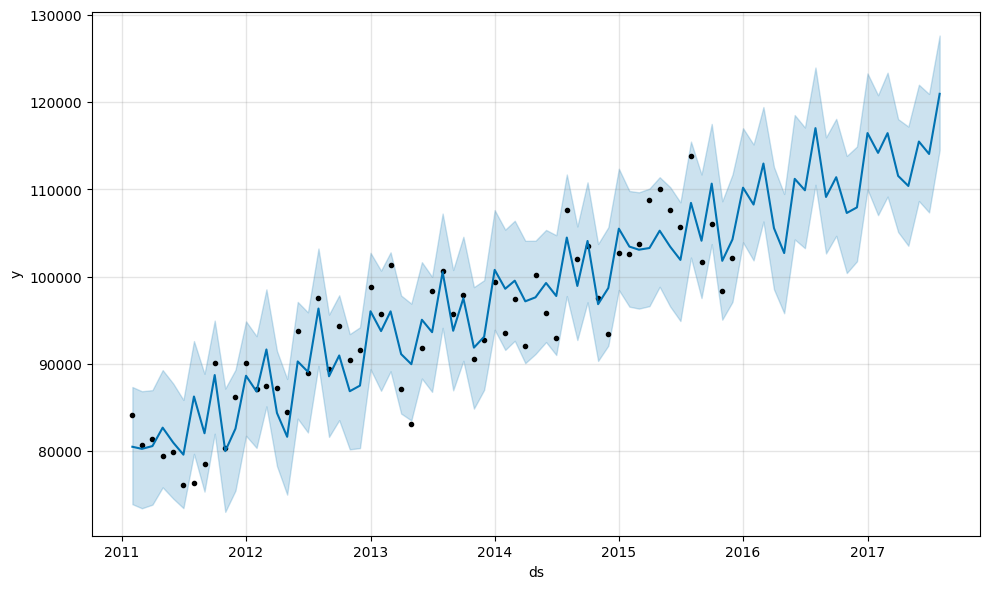

In [ ]:
plot1 = m.plot(forecast)

In [ ]:
x = forecast[forecast['ds'] > '2015-01']
x = x[['ds', 'yhat']]
x.nlargest(5, 'yhat')

,ds,yhat
52,2016-10-01,111.505738
35,2015-05-01,82.126103
51,2016-09-01,81.398863
46,2016-04-01,81.138365
41,2015-11-01,74.884022


In [ ]:
forecast['ds'] = forecast['ds'].dt.strftime('%Y-%m')

AttributeError: Can only use .dt accessor with datetimelike values

In [ ]:
df_real = pd.DataFrame(selecionados)

In [ ]:
dados_prophet['ds'] = dados_prophet['ds'].dt.strftime('%Y-%m')

AttributeError: Can only use .dt accessor with datetimelike values

In [ ]:
dados_prophet

,ds,y
0,2011-02,84150.579200
1,2011-03,80708.581100
2,2011-04,81369.549125
3,2011-05,79457.614360
4,2011-06,79944.519100
5,2011-07,76161.317500
6,2011-08,76384.806180
7,2011-09,78507.757700
8,2011-10,90131.636075
9,2011-11,80342.496250


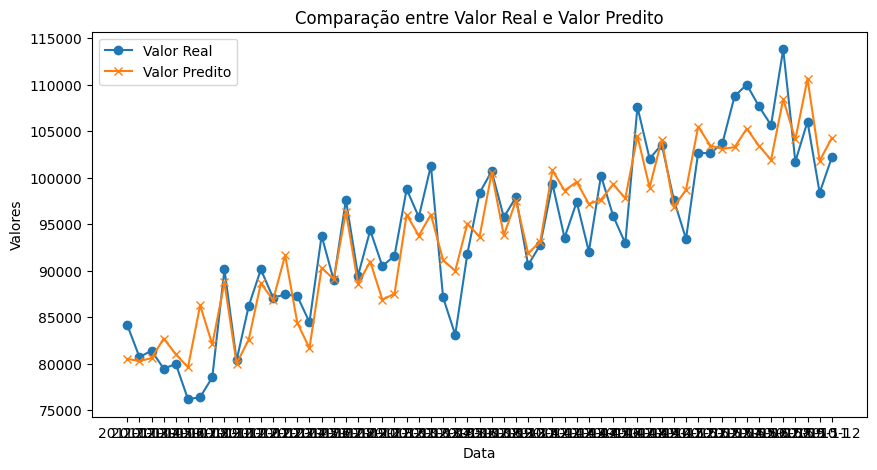

In [ ]:
# Mesclar previsões com dados reais
df_merged = pd.merge(df_real, forecast[['ds', 'yhat']], on='ds', how='left')

df_merged


forecast[['ds', 'yhat']]

# Plotando os dados
plt.figure(figsize=(10, 5))
plt.plot(df_merged['ds'], df_merged['y'], label='Valor Real', marker='o')
plt.plot(df_merged['ds'], df_merged['yhat'], label='Valor Predito', marker='x')

# Adicionando título e rótulos
plt.title('Comparação entre Valor Real e Valor Predito')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.legend()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_j2q1szg/nd_ig2sd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_j2q1szg/zgnhy4p7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60016', 'data', 'file=/tmp/tmp_j2q1szg/nd_ig2sd.json', 'init=/tmp/tmp_j2q1szg/zgnhy4p7.json', 'output', 'file=/tmp/tmp_j2q1szg/prophet_models2hv_sp_/prophet_model-20241011031437.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:14:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:14:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


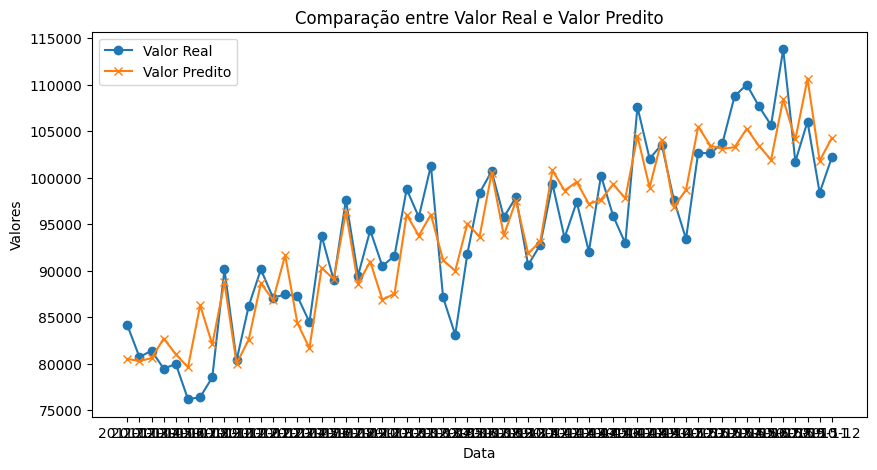

In [ ]:
    !pip install plotly_express
    import plotly.express as px
    dados_prophet = selecionados.rename(columns={'year_month': 'ds', 'SOMA': 'y'})

    modelo = Prophet()
    modelo.fit(dados_prophet)
    futuro = modelo.make_future_dataframe(periods=20, freq='MS')
    previsao = modelo.predict(futuro)

    # Plotar os resultados
    fig = px.line(previsao, x='ds', y='yhat', title='Previsão com Prophet')



    previsao['ds'] = previsao['ds'].dt.strftime('%Y-%m')
    df_real = pd.DataFrame(dados_prophet)
    df_merged = pd.merge(df_real, previsao[['ds', 'yhat']], on='ds', how='left')
    df_merged

    # Plotando os dados
    plt.figure(figsize=(10, 5))
    plt.plot(df_merged['ds'], df_merged['y'], label='Valor Real', marker='o')
    plt.plot(df_merged['ds'], df_merged['yhat'], label='Valor Predito', marker='x')

    # Adicionando título e rótulos
    plt.title('Comparação entre Valor Real e Valor Predito')
    plt.xlabel('Data')
    plt.ylabel('Valores')
    plt.legend()

In [ ]:
dados_prophet

,ds,y
0,2011-02,84150.579200
1,2011-03,80708.581100
2,2011-04,81369.549125
3,2011-05,79457.614360
4,2011-06,79944.519100
5,2011-07,76161.317500
6,2011-08,76384.806180
7,2011-09,78507.757700
8,2011-10,90131.636075
9,2011-11,80342.496250


In [ ]:
df_merged

,ds,y,yhat
0,2011-02,84150.579200,80503.670454
1,2011-03,80708.581100,80264.498391
2,2011-04,81369.549125,80584.218862
3,2011-05,79457.614360,82693.080083
4,2011-06,79944.519100,80983.705901
5,2011-07,76161.317500,79599.067118
6,2011-08,76384.806180,86263.371675
7,2011-09,78507.757700,82051.138282
8,2011-10,90131.636075,88720.981659
9,2011-11,80342.496250,80003.553146


In [ ]:
final = dados_filtrados.groupby(['Cluster'])[['SOMA']].sum().reset_index()

In [ ]:
final['SOMA_TOTAL'] = final['SOMA'].sum()
final['PERCENTUAL_SOMA'] = final['SOMA'] / final['SOMA_TOTAL']
final['SOMA'] = final['SOMA'].apply(lambda x: f'R${x:,.2f}')
final['SOMA_TOTAL'] = final['SOMA_TOTAL'].apply(lambda x: f'R${x:,.2f}')
final['PERCENTUAL_SOMA'] = final['PERCENTUAL_SOMA'].apply(lambda x: f'{x * 100:.2f}%')
print(final)

NameError: name 'final' is not defined

In [ ]:
final2 = dados_filtrados.groupby(['Cluster'])[['sales']].sum().reset_index()

In [ ]:
final2['sales_TOTAL'] = final2['sales'].sum()
final2['PERCENTUAL_SALES'] = final2['sales'] / final2['sales_TOTAL']
final2['sales'] = final2['sales'].apply(lambda x: f'{int(x):,}'.replace(',', '.'))
final2['sales_TOTAL'] = final2['sales_TOTAL'].apply(lambda x: f'{int(x):,}'.replace(',', '.'))
final2['PERCENTUAL_SALES'] = final2['PERCENTUAL_SALES'].apply(lambda x: f'{x * 100:.2f}%')
print(final2)

   Cluster      sales sales_TOTAL PERCENTUAL_SALES
0        0  2.912.655   9.779.366           29.78%
1        1    317.870   9.779.366            3.25%
2        2  2.919.604   9.779.366           29.85%
3        3  1.504.245   9.779.366           15.38%
4        4  2.124.992   9.779.366           21.73%


In [ ]:
final3 = dados_filtrados.groupby(['Cluster'])[['mean_price']].mean().reset_index()

In [ ]:
final3['mean_price_TOTAL'] = final3['mean_price'].sum()
final3['PERCENTUAL_MEAN'] = final3['mean_price'] / final3['mean_price_TOTAL']

final3['mean_price'] = final3['mean_price'].apply(lambda x: f'R${x:,.2f}')
final3['mean_price_TOTAL'] = final3['mean_price_TOTAL'].apply(lambda x: f'R${x:,.2f}')
final3['PERCENTUAL_MEAN'] = final3['PERCENTUAL_MEAN'].apply(lambda x: f'{x * 100:.2f}%')
final3

,Cluster,mean_price,mean_price_TOTAL,PERCENTUAL_MEAN
0,0,R$3.42,R$25.35,13.51%
1,1,R$13.40,R$25.35,52.86%
2,2,R$1.96,R$25.35,7.72%
3,3,R$0.96,R$25.35,3.79%
4,4,R$5.61,R$25.35,22.13%


In [ ]:

# Juntando final e final2
merged_df = pd.merge(final, final2, on='Cluster', how='outer')

# Juntando o resultado com final3
merged_df = pd.merge(merged_df, final3, on='Cluster', how='outer')

merged_df


,Cluster,SOMA,SOMA_TOTAL,PERCENTUAL_SOMA,sales,sales_TOTAL,PERCENTUAL_SALES,mean_price,mean_price_TOTAL,PERCENTUAL_MEAN
0,0,"R$9,601,636.88","R$31,908,467.42",30.09%,2.912.655,9.779.366,29.78%,R$3.42,R$25.35,13.51%
1,1,"R$4,033,458.44","R$31,908,467.42",12.64%,317.870,9.779.366,3.25%,R$13.40,R$25.35,52.86%
2,2,"R$5,548,533.69","R$31,908,467.42",17.39%,2.919.604,9.779.366,29.85%,R$1.96,R$25.35,7.72%
3,3,"R$1,357,276.27","R$31,908,467.42",4.25%,1.504.245,9.779.366,15.38%,R$0.96,R$25.35,3.79%
4,4,"R$11,367,562.13","R$31,908,467.42",35.63%,2.124.992,9.779.366,21.73%,R$5.61,R$25.35,22.13%


In [ ]:
merged_df


,Cluster,SOMA,SOMA_TOTAL,PERCENTUAL_SOMA,sales,sales_TOTAL,PERCENTUAL_SALES,mean_price,mean_price_TOTAL,PERCENTUAL_MEAN
0,0,"R$9,601,636.88","R$31,908,467.42",30.09%,2.912.655,9.779.366,29.78%,R$3.42,R$25.35,13.51%
1,1,"R$4,033,458.44","R$31,908,467.42",12.64%,317.870,9.779.366,3.25%,R$13.40,R$25.35,52.86%
2,2,"R$5,548,533.69","R$31,908,467.42",17.39%,2.919.604,9.779.366,29.85%,R$1.96,R$25.35,7.72%
3,3,"R$1,357,276.27","R$31,908,467.42",4.25%,1.504.245,9.779.366,15.38%,R$0.96,R$25.35,3.79%
4,4,"R$11,367,562.13","R$31,908,467.42",35.63%,2.124.992,9.779.366,21.73%,R$5.61,R$25.35,22.13%


In [ ]:
def top5_per_group(df):
    return df.nlargest(5, 'SOMA')

top5_by_cluster = final4.groupby('Cluster').apply(top5_per_group).reset_index(drop=True)
top5_by_cluster
top5_by_cluster['SOMA'] = top5_by_cluster['SOMA'].apply(lambda x: f'R${x:,.2f}')

In [ ]:
top5_by_cluster

,Cluster,id,SOMA
0,0,SUPERMARKET_3_551_BOS_2,"R$13,881.78"
1,0,SUPERMARKET_3_551_BOS_3,"R$13,535.55"
2,0,SUPERMARKET_3_551_BOS_1,"R$13,486.36"
3,0,SUPERMARKET_3_035_BOS_2,"R$13,328.22"
4,0,SUPERMARKET_3_533_BOS_1,"R$12,523.70"
5,1,SUPERMARKET_2_054_BOS_2,"R$14,375.77"
6,1,SUPERMARKET_2_164_BOS_3,"R$14,307.61"
7,1,HOME_&_GARDEN_1_319_BOS_1,"R$14,226.03"
8,1,SUPERMARKET_2_347_BOS_1,"R$14,004.31"
9,1,HOME_&_GARDEN_1_294_BOS_1,"R$13,831.71"


In [ ]:
kmeans2 = joblib.load('kmeans_model_Boston.pkl')

In [ ]:

# VERIFICANDO O SILHOUETTE_SCORE

from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(df, df['Grupo'])

print(f"A pontuação de silhueta média é: {silhouette_avg}")




A pontuação de silhueta média é: 0.6333687671983006


In [ ]:
# VERIFICANDO CURVA DE ELBOW

K_range = range(1,12)
K_range
k_means_var = [KMeans(n_clusters = k).fit(df) for k in K_range]
k_means_var

[KMeans(n_clusters=1),
 KMeans(n_clusters=2),
 KMeans(n_clusters=3),
 KMeans(n_clusters=4),
 KMeans(n_clusters=5),
 KMeans(n_clusters=6),
 KMeans(n_clusters=7),
 KMeans(),
 KMeans(n_clusters=9),
 KMeans(n_clusters=10),
 KMeans(n_clusters=11)]

Text(0.5, 1.0, 'Variância Explicada para cada valor de K')

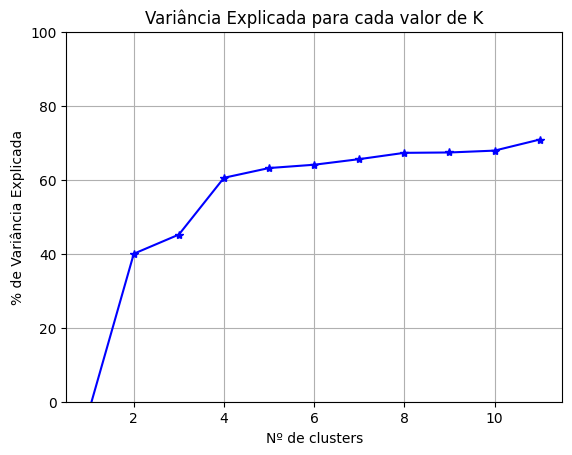

In [ ]:
####CURVA DE ELBOW  - EXPLICAR A VARIÂNCIA - CONSOME MUITA RAM - FAZER COM 1%

#Ajustando o centróide (centro de cada cluster) do cluster para cada modelo
centroids = [X.cluster_centers_ for X in k_means_var]

### Calculando a distância euclidiana de cada ponto de dado para o centróide

k_euclid = [cdist(df, cent, 'euclidean') for cent in centroids]
dist = [np.min(ke, axis = 1) for ke in k_euclid]

#Soma dos quadrados das distâncias dentro do cluster
soma_quadrados_intra_cluster = [sum(d**2) for d in dist]

#Soma total dos quadrados
soma_total = sum(pdist(df)**2/df.shape[0])

#Soma dos quadrados entre clusters

soma_quadrados_intra_cluster = soma_total - soma_quadrados_intra_cluster

# Curva de Elbow

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K_range, soma_quadrados_intra_cluster/soma_total *100, 'b*-')
ax.set_ylim((0,100))
plt.grid(True)
plt.xlabel('Nº de clusters')
plt.ylabel('% de Variância Explicada')
plt.title('Variância Explicada para cada valor de K')


######   a PARTIR DE 4, A DIFERENÇA DE VARIÂNCIA É PEQUENA, PORTANTO, É BOM TERMOS SÓ 4 CLUSTERS